# Prototype 6 - Custom 1 + Keras dataset loader

## 1. Determine the absolute path of the dataset based on a provided relative path

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Get the absolute path of the dataset
dataset_dir = os.path.abspath('../datasets/FINAL DATASET')
# dataset_dir = "C:\\Users\\rektplorer64\\OneDrive\\Pictures\\Wallpapers"

class_names = list(filter(lambda x: ".py" not in x, os.listdir(dataset_dir)))

print('There are', len(class_names), 'classes as follows:')
print(class_names)


There are 38 classes as follows:
['stewed_pork_leg', 'caesar_salad', 'noodles_without_soup', 'coconut_milk_soup', 'kebab', 'hot_and_sour_fish_and_vegetable_ragout', 'steak_with_rice', 'chow_mein', 'noodles_with_fish_curry', 'pizza', 'crispy_pork_with_kale_with_rice', 'yellow_curry', 'rice_crispy_pork', 'rice_topped_with_stir_fried_meat_and_basil', 'omelette', 'steamed_chicken_with_rice', 'spring_rolls', 'pad_see_ew', 'spicy_stir_fried_pork_with_red_curry_paste', 'spaghetti_bolognese', 'barbecued_red_pork_in_sauce_with_rice', 'fried_rice', 'pad_thai', 'hamburger', 'onion_rings', 'khao_soi', 'fried_chicken_with_rice', 'green_curry', 'spicy_chicken_salad_with_rice', 'spaghetti_carbonara', 'peking_duck', 'steamed_rice_roll', 'fried_pork_with_rice', 'steak', 'charcoal-boiled_pork_neck', 'noodles', 'thai_papaya_salad', 'fried_mussel_pancakes']


In [2]:
# Configure these hyper-params
batch_size = 24
image_size = (256, 256)
random_seed = 12312312

In [3]:
def crop_center(image):
    
#     print(image.get_shape())
    h, w = image.shape[-3], image.shape[-2]

    if h > w:
        cropped_image = tf.image.crop_to_bounding_box(image, (h - w) // 2, 0, w, w)
    else:
        cropped_image = tf.image.crop_to_bounding_box(image, 0, (w - h) // 2, h, h)
    return tf.image.resize_images(cropped_image, image_size)

def decode_img(img, img_size):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  
  # resize the image to the desired size
  img = tf.image.resize(img, [img_size[0], img_size[1]])
  return img

def process_path(file_path, class_names, img_size):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img, img_size)
  return img


def map_load_image(file_path, label):
#     print(file_path, label)
    final_one_hot_label = label == class_names
    return process_path(file_path, class_names, image_size), tf.argmax(final_one_hot_label)

In [4]:
import tensorflow as tf

from tensorflow.data import Dataset
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

from keras.preprocessing.image import ImageDataGenerator

import numpy as np
from sklearn.model_selection import train_test_split

from extract_label_from_url import extract_label_from_url

import glob
import random


#  -----------------------------------------------------------------------------
# Take a look at each folder to get its files' url
image_filepath_list = glob.glob(dataset_dir + '/*/*')

# Image Count => count its length
image_count = len(image_filepath_list)
print('There are', image_count, 'images in the dataset.')

# Infer label from each url
image_dataset_labels = list(map(lambda x: extract_label_from_url(x), image_filepath_list))
# print(image_dataset_labels)

#  -----------------------------------------------------------------------------
# Split for [Training + Validation] set & [Testing] set
X_train_val, X_test, y_train_val, y_test = train_test_split(image_filepath_list, image_dataset_labels, test_size=0.2, random_state=1, stratify=image_dataset_labels)

# Split again for [Training] set & [Testing] set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1, stratify=y_train_val) # 0.25 x 0.8 = 0.2

# Show dataset splits summary
print('Training Set\tsize:\t', len(X_train), '\tlabel:',len(y_train))
print('Validation Set\tsize:\t', len(X_val), '\tlabel:',len(y_val))
print('Testing Set\tsize:\t', len(X_test), '\tlabel:',len(y_test))
print('Total Dataset\tsize:\t', len(X_train) + len(X_val) + len(X_test))

# List 5 sample files
print('\n\nSample 5 images -------------------')
for f in random.sample(image_filepath_list, 5):
  print(extract_label_from_url(f), '\n', f, '\n')

# FORM TENSORFLOW DATASETS: https://www.tensorflow.org/api_docs/python/tf/data/Dataset?version=nightly#from_tensor_slices
#  -----------------------------------------------------------------------------


# STEP 1: Training set formation
dataset_train_X = Dataset.from_tensor_slices(X_train)
dataset_train_Y = Dataset.from_tensor_slices(y_train)
dataset_train = Dataset.zip((dataset_train_X, dataset_train_Y))

# STEP 2: Validation set formation
dataset_val_X = Dataset.from_tensor_slices(X_val)
dataset_val_Y = Dataset.from_tensor_slices(y_val)
dataset_val = Dataset.zip((dataset_val_X, dataset_val_Y))

# STEP 3: Testing set formation
dataset_test_X = Dataset.from_tensor_slices(X_test)
dataset_test_Y = Dataset.from_tensor_slices(y_test)
dataset_test = Dataset.zip((dataset_test_X, dataset_test_Y))

# STEP 4: Covert tensor slices of (image url, label) to actual image that will be loaded later
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.

AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train = dataset_train.map(map_load_image, num_parallel_calls=AUTOTUNE).batch(batch_size)
ds_val = dataset_val.map(map_load_image, num_parallel_calls=AUTOTUNE).batch(batch_size)
ds_test = dataset_test.map(map_load_image, num_parallel_calls=AUTOTUNE).batch(batch_size)

print("\n\nDatastore Metadata ----------------------")
for image, label in ds_train.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
for image_batch, labels_batch in ds_train:
    image_size_with_color = image_batch[0].shape
    print("\nThe DIMENSION OF One Batch of images", image_batch.shape)
    print("The Batches size", labels_batch.shape)
    break

There are 9500 images in the dataset.
Training Set	size:	 5700 	label: 5700
Validation Set	size:	 1900 	label: 1900
Testing Set	size:	 1900 	label: 1900
Total Dataset	size:	 9500


Sample 5 images -------------------
rice_topped_with_stir_fried_meat_and_basil 
 /home/psimilan/psimilan-notebooks/pooh/ITCS402-PJ_Thai_Food_Image_Recognition/datasets/FINAL DATASET/rice_topped_with_stir_fried_meat_and_basil/rice_basil-ThaiFoodDataset-080.jpg 

coconut_milk_soup 
 /home/psimilan/psimilan-notebooks/pooh/ITCS402-PJ_Thai_Food_Image_Recognition/datasets/FINAL DATASET/coconut_milk_soup/coconut_milk_soup-ThaiFoodDataset-034.jpg 

spicy_stir_fried_pork_with_red_curry_paste 
 /home/psimilan/psimilan-notebooks/pooh/ITCS402-PJ_Thai_Food_Image_Recognition/datasets/FINAL DATASET/spicy_stir_fried_pork_with_red_curry_paste/pork_red_curry_paste-ThaiFoodDataset-146.jpg 

thai_papaya_salad 
 /home/psimilan/psimilan-notebooks/pooh/ITCS402-PJ_Thai_Food_Image_Recognition/datasets/FINAL DATASET/thai_papaya_salad

## * Show some images in the dataset

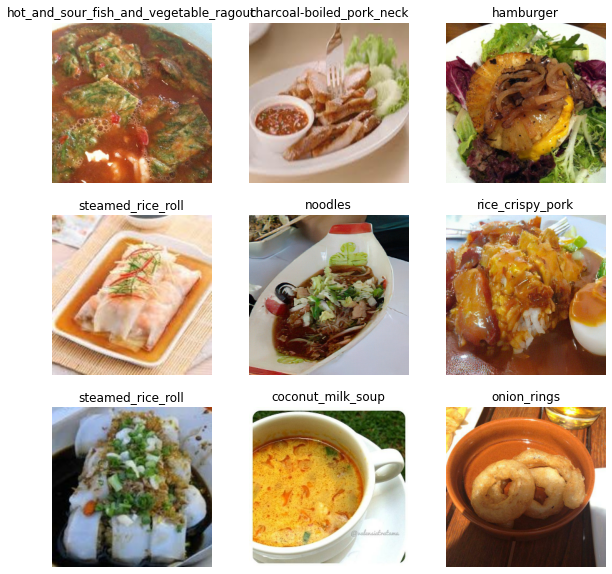

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
#     print(labels)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
       
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")

In [6]:
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop, Rescaling, RandomFlip, RandomRotation, RandomZoom

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, LeakyReLU
from keras.layers.normalization import BatchNormalization

model = Sequential()

## Input Layer
model.add(keras.Input(shape=image_size_with_color))

## Input Preprocessing Layers: https://www.tensorflow.org/guide/keras/preprocessing_layers
data_augmentation = keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomFlip("vertical"),
        RandomRotation(0.1),
        RandomZoom(0.1),
    ], "preprocessing"
)
model.add(data_augmentation)


# norm_layer = keras.layers.experimental.preprocessing.Normalization()
# mean = np.array([127.5] * 3)
# var = mean ** 2
# # norm_layer.adapt(ds_train)
# # Scale inputs to [-1, +1]
# x = norm_layer(data_augmentation)
# norm_layer.set_weights([mean, var])

# x = tf.keras.applications.resnet_v2.preprocess_input(model)
# model.add(x)

# x = tf.keras.layers.LayerNormalization(axis=1 , center=True , scale=True)(data_augmentation)

model.add(Rescaling(scale=1.0/255.0))


model.add(Conv2D(96, 9, input_shape=image_size_with_color, padding="same",  activation='relu'))
model.add(Conv2D(96, 9, activation='relu'))
model.add(Conv2D(96, 9, activation='relu'))
model.add(MaxPooling2D((2, 2), name="pool1"))
model.add(BatchNormalization())

model.add(Conv2D(64, 5, activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())

model.add(Conv2D(64, 5, activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())

model.add(Conv2D(64, 4, activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
# model.add(Conv2D(72, 4))
# model.add(LeakyReLU())
# model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(124, 4))
model.add(LeakyReLU())
model.add(MaxPooling2D(2, 2))
# model.add(Conv2D(128, 3, activation='relu'))

model.add(GlobalAveragePooling2D())

model.add(Dense(100, activation = 'relu'))
model.add(Dense(76, activation = 'relu'))
model.add(Dense(len(class_names), activation = 'softmax'))


opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing (Sequential)   (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 96)      23424     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 248, 248, 96)      746592    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 240, 240, 96)      746592    
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 120, 120, 96)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 120, 96)      3

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

# early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')
# reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='auto', min_lr=0.00001)
model_training_history = model.fit(ds_train,
#         steps_per_epoch=int(np.ceil(len(X_train) / batch_size)),
        epochs=400,
        validation_data=ds_val,
#         validation_steps=int(np.ceil(len(X_val)  / batch_size)),
        verbose=1 
          ,callbacks=[
#               early, 
              tfdocs.modeling.EpochDots()
#               reduce
          ]
         )

Epoch 1/400
238/238 [==============================] - ETA: 0s - loss: 3.6257 - accuracy: 0.0388
Epoch: 0, accuracy:0.0388,  loss:3.6257,  val_accuracy:0.0263,  val_loss:3.6652,  
238/238 [==============================] - 144s 605ms/step - loss: 3.6257 - accuracy: 0.0388 - val_loss: 3.6652 - val_accuracy: 0.0263
Epoch 2/400
238/238 [==============================] - 142s 598ms/step - loss: 3.4812 - accuracy: 0.0667 - val_loss: 3.6185 - val_accuracy: 0.0532
Epoch 3/400
238/238 [==============================] - 142s 598ms/step - loss: 3.4060 - accuracy: 0.1018 - val_loss: 3.4799 - val_accuracy: 0.0816
Epoch 4/400
238/238 [==============================] - 142s 598ms/step - loss: 3.3409 - accuracy: 0.1209 - val_loss: 3.3988 - val_accuracy: 0.0926
Epoch 5/400
238/238 [==============================] - 142s 598ms/step - loss: 3.2741 - accuracy: 0.1433 - val_loss: 3.3301 - val_accuracy: 0.1126
Epoch 6/400
238/238 [==============================] - 142s 598ms/step - loss: 3.2130 - accuracy:

238/238 [==============================] - 142s 597ms/step - loss: 1.7333 - accuracy: 0.4846 - val_loss: 2.2037 - val_accuracy: 0.3600
Epoch 54/400
238/238 [==============================] - 142s 596ms/step - loss: 1.7111 - accuracy: 0.4926 - val_loss: 2.1298 - val_accuracy: 0.3789
Epoch 55/400
238/238 [==============================] - 142s 596ms/step - loss: 1.6977 - accuracy: 0.4958 - val_loss: 2.1867 - val_accuracy: 0.3537
Epoch 56/400
238/238 [==============================] - 142s 596ms/step - loss: 1.6812 - accuracy: 0.4986 - val_loss: 2.0947 - val_accuracy: 0.3774
Epoch 57/400
238/238 [==============================] - 142s 596ms/step - loss: 1.6624 - accuracy: 0.4993 - val_loss: 2.1346 - val_accuracy: 0.3674
Epoch 58/400
238/238 [==============================] - 142s 596ms/step - loss: 1.6477 - accuracy: 0.5032 - val_loss: 2.1680 - val_accuracy: 0.3742
Epoch 59/400
238/238 [==============================] - 142s 596ms/step - loss: 1.6320 - accuracy: 0.5100 - val_loss: 2.0726 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



238/238 [==============================] - 142s 595ms/step - loss: 1.1513 - accuracy: 0.6463 - val_loss: 2.0368 - val_accuracy: 0.4158
Epoch 108/400
238/238 [==============================] - 142s 596ms/step - loss: 1.1441 - accuracy: 0.6439 - val_loss: 1.8441 - val_accuracy: 0.4521
Epoch 109/400
238/238 [==============================] - 142s 595ms/step - loss: 1.1341 - accuracy: 0.6525 - val_loss: 2.0684 - val_accuracy: 0.4258
Epoch 110/400
238/238 [==============================] - 142s 595ms/step - loss: 1.1356 - accuracy: 0.6463 - val_loss: 1.9280 - val_accuracy: 0.4411
Epoch 111/400
238/238 [==============================] - 142s 595ms/step - loss: 1.1276 - accuracy: 0.6554 - val_loss: 1.9675 - val_accuracy: 0.4284
Epoch 112/400
155/238 [==================>...........] - ETA: 47s - loss: 1.1434 - accuracy: 0.6454

In [ ]:
# base_model.trainable = True
# model.summary()

# model.compile(
#     optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
#     loss='sparse_categorical_crossentropy',
#     metrics=["accuracy"],
# )

# epochs_finetune = 15
# model_training_history_2 = model.fit(ds_train, epochs=epochs_finetune, validation_data=ds_val)

In [ ]:
!mkdir -p saved_model
model.save('saved_model/prototype6_custom1-loader2')

In [ ]:
# !pip install -q git+https://github.com/tensorflow/docs

# summarize history for loss
plt.plot(model_training_history.history['loss'])
plt.plot(model_training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(model_training_history.history['accuracy'])
plt.plot(model_training_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.ylim(0, 1)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = np.array([])
true_labels = np.array([])
print(images.shape)

count = 0
for image, true_label in ds_test:
#     print(images.shape, image.shape)
#     if count == 0:
#         images = image
#     else:
#         np.append(images, image)
#     count += 1
# #     np.concatenate((images, image))
# #     np.concatenate((true_labels, true_label))
    prediction = np.argmax(model.predict(image), axis=1)
    
    predictions = np.append(predictions, prediction)
    true_labels = np.append(true_labels, true_label)

print(images.shape, true_labels.shape)
# print(images, true_labels)
    
# print(ds_test)
# raw_predictions = model.predict(images)

# test_predictions = np.argmax(raw_predictions, axis=1)
# test_prediction_label = np.argmax(raw_predictions, axis=-1)
print("Prediction", predictions.shape, predictions)
# print("Test Prediction Label", test_prediction_label.shape, test_prediction_label)


# predictions_labels = list(map(lambda x: class_names.index(x), y_test))
# print(len(predictions_labels), predictions_labels)
confusion_matrix = confusion_matrix(predictions, true_labels)
print("\nConfusion Matrix ---------------------------\n", confusion_matrix)

# evaluation = model.evaluate(X_test, y_test, 20)
print(type(confusion_matrix))

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 18)

im = ax.imshow(confusion_matrix, cmap="YlGnBu")

# We want to show all ticks...
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
# ... and label them with the respective list entries
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(class_names)):
    for j in range(len(class_names)):
        color = 'k'
        if confusion_matrix[i, j] > 25:
            color = 'w'
        
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color=color, fontfamily="monospace", fontsize=14)

ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Report Util: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report
print(classification_report(predictions, true_labels, target_names=class_names))

In [ ]:
import collections
counter=collections.Counter(y_test)
print(counter)